In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
class MBGWO:
    def __init__(self, num_features, num_wolves=10, max_iter=50, randomness_factor=0.15):
       
        self.num_features = num_features
        self.num_wolves = num_wolves
        self.max_iter = max_iter
        self.randomness_factor = randomness_factor
        self.Alpha_pos = None
        self.Alpha_score = float("inf")
        self.Beta_pos = None
        self.Beta_score = float("inf")
        self.Delta_pos = None
        self.Delta_score = float("inf")
        self.convergence_curve = np.zeros(max_iter)
        # Set random seed based on current time to ensure different runs give different results
        np.random.seed(int(time.time()) % 10000)
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-10 * (x - 0.5)))
    
    def initialize_population(self):
        return np.random.randint(2, size=(self.num_wolves, self.num_features))
    
    def calculate_fitness(self, wolf_position, X, y, alpha=0.95):
       
        # Get selected feature indices
        selected_features = np.where(wolf_position == 1)[0]
        
        if len(selected_features) == 0:
            return 1.0  # Penalize solutions with no features selected
        
        # Extract selected features from dataset
        X_selected = X[:, selected_features]
        
        # Split data for evaluation
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
        
        # Use Random Forest for evaluation (replacing SVM)
        clf = RandomForestClassifier(n_estimators=20, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Calculate error rate
        error_rate = 1 - accuracy_score(y_test, y_pred)
        
        # Calculate the ratio of selected features
        feature_ratio = len(selected_features) / self.num_features
        
        # Calculate fitness (lower is better)
        fitness = alpha * error_rate + (1 - alpha) * feature_ratio
        
        return fitness
    
    def update_position(self, current_pos, A, C, leader_pos):
        D = np.abs(C * leader_pos - current_pos)
        updated_pos = leader_pos - A * D
        
        # Apply sigmoid function to convert to probability
        sigmoid_pos = self.sigmoid(updated_pos)
        
        # Add randomness to make feature selection more dynamic
        random_factor = np.random.random(len(sigmoid_pos)) * self.randomness_factor
        sigmoid_pos = sigmoid_pos * (1 - self.randomness_factor) + random_factor
        
        # Convert to binary based on probability
        binary_pos = np.zeros_like(current_pos)
        binary_pos[sigmoid_pos >= np.random.random(len(sigmoid_pos))] = 1
        
        return binary_pos
    
    def optimize(self, X, y):
       
        print("Starting MBGWO optimization with swarm intelligence...")
        
        # Initialize population
        wolves = self.initialize_population()
        
        # Main loop
        for t in range(self.max_iter):
            # Update Alpha, Beta, and Delta
            for i in range(self.num_wolves):
                # Calculate fitness
                fitness = self.calculate_fitness(wolves[i], X, y)
                
                # Update Alpha, Beta, Delta
                if fitness < self.Alpha_score:
                    self.Delta_score = self.Beta_score
                    self.Delta_pos = self.Beta_pos.copy() if self.Beta_pos is not None else None
                    self.Beta_score = self.Alpha_score
                    self.Beta_pos = self.Alpha_pos.copy() if self.Alpha_pos is not None else None
                    self.Alpha_score = fitness
                    self.Alpha_pos = wolves[i].copy()
                elif fitness < self.Beta_score:
                    self.Delta_score = self.Beta_score
                    self.Delta_pos = self.Beta_pos.copy() if self.Beta_pos is not None else None
                    self.Beta_score = fitness
                    self.Beta_pos = wolves[i].copy()
                elif fitness < self.Delta_score:
                    self.Delta_score = fitness
                    self.Delta_pos = wolves[i].copy()
            
            # Update a, A, and C coefficients
            a = 2 - t * (2 / self.max_iter)
            
            # Update positions
            for i in range(self.num_wolves):
                # Update coefficients
                A1 = 2 * a * np.random.random(self.num_features) - a
                C1 = 2 * np.random.random(self.num_features)
                A2 = 2 * a * np.random.random(self.num_features) - a
                C2 = 2 * np.random.random(self.num_features)
                A3 = 2 * a * np.random.random(self.num_features) - a
                C3 = 2 * np.random.random(self.num_features)
                
                # Update position based on Alpha, Beta, Delta
                pos1 = self.update_position(wolves[i], A1, C1, self.Alpha_pos)
                pos2 = self.update_position(wolves[i], A2, C2, self.Beta_pos)
                pos3 = self.update_position(wolves[i], A3, C3, self.Delta_pos)
                
                # Combine positions (majority voting)
                wolves[i] = np.zeros(self.num_features)
                for j in range(self.num_features):
                    if (pos1[j] + pos2[j] + pos3[j]) >= 2:
                        wolves[i][j] = 1
            
            # Store best score of current iteration
            self.convergence_curve[t] = self.Alpha_score
            
            if (t + 1) % 10 == 0 or t == 0 or t == self.max_iter - 1:
                num_selected = np.sum(self.Alpha_pos)
                print(f"Iteration {t+1}/{self.max_iter}, Best fitness: {self.Alpha_score:.4f}, "
                      f"Selected features: {num_selected}/{self.num_features}")
        
        return self.Alpha_pos, self.Alpha_score, self.convergence_curve
    
    def get_selected_features(self):
        if self.Alpha_pos is None:
            return []
        return np.where(self.Alpha_pos == 1)[0]

In [3]:
def load_and_preprocess_data(file_path, sample_size=10000):
   
    print("Loading and preprocessing dataset...")
    
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Sample the dataset to reduce size
    if sample_size and len(df) > sample_size:
        df = df.sample(sample_size, random_state=int(time.time()) % 10000)
    
    print(f"Dataset shape after sampling: {df.shape}")
    
    # Display dataset info
    print("\nDataset information:")
    print(df.info())
    
    # Handle missing values
    print("\nHandling missing values...")
    for col in df.columns:
        if df[col].dtype != 'object' and df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
        elif df[col].dtype == 'object' and df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    # Focus more on packet-related features
    packet_features = [col for col in df.columns if any(term in col.lower() 
                      for term in ['pkts', 'bytes', 'packet', 'flow', 'tcp', 'ip'])]
    
    print(f"Identified {len(packet_features)} packet-related features")
    
    # Make a copy of the original dataframe for later reference
    original_df = df.copy()
    
    # Separate features and target
    if 'Attack' in df.columns:
        X_df = df.drop(['Attack', 'Label'], axis=1, errors='ignore')
        y = df['Attack']  # Using 'Attack' column as target
    else:
        X_df = df.iloc[:, :-1]  # All columns except last
        y = df.iloc[:, -1]      # Last column as target
    
    feature_names = list(X_df.columns)
    
    # Encode categorical features
    categorical_cols = [col for col in X_df.columns if X_df[col].dtype == 'object']
    
    encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_df[col] = le.fit_transform(X_df[col].astype(str))
        encoders[col] = le
    
    X = X_df.values
    
    # Encode target if needed
    target_encoder = None
    if y.dtype == 'object':
        target_encoder = LabelEncoder()
        y = target_encoder.fit_transform(y.astype(str))
        print(f"\nTarget classes: {target_encoder.classes_}")
        encoders['target'] = target_encoder
    
    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("Data preprocessing completed.")
    return X_scaled, y, feature_names, original_df, encoders, scaler

In [4]:
def evaluate_model(X_train, X_test, y_train, y_test, selected_features=None):
  
    # Select features if specified
    if selected_features is not None:
        if len(selected_features) == 0:
            print("No features selected. Using all features.")
            X_train_selected = X_train
            X_test_selected = X_test
        else:
            X_train_selected = X_train[:, selected_features]
            X_test_selected = X_test[:, selected_features]
    else:
        X_train_selected = X_train
        X_test_selected = X_test
    
    # Create and train the Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Measure training time
    start_time = time.time()
    model.fit(X_train_selected, y_train)
    training_time = time.time() - start_time
    
    # Measure prediction time
    start_time = time.time()
    y_pred = model.predict(X_test_selected)
    prediction_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Calculate feature importance if features were selected
    if selected_features is not None and len(selected_features) > 0:
        feature_importance = model.feature_importances_
    else:
        feature_importance = None
    
    # Return metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time,
        'prediction_time': prediction_time,
        'num_features': X_train_selected.shape[1],
        'model': model,
        'y_pred': y_pred,
        'feature_importance': feature_importance
    }

In [5]:
def plot_results(convergence_curve, rf_results, selected_features, feature_names, y_test, y_pred_rf):
    print("\nGenerating result visualizations...")

    # Plot 1: Convergence curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(convergence_curve) + 1), convergence_curve, marker='o')
    plt.title('MBGWO Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness Value')
    plt.grid(True)
    plt.show()

    # Plot 2: Selected Features
    if len(selected_features) > 0:
        selected_feature_names = [feature_names[i] for i in selected_features]
        plt.figure(figsize=(12, max(6, len(selected_feature_names) * 0.3)))
        y_pos = np.arange(len(selected_feature_names))
        plt.barh(y_pos, np.ones(len(selected_feature_names)), align='center')
        plt.yticks(y_pos, selected_feature_names)
        plt.xlabel('Selected')
        plt.title(f'Selected Features ({len(selected_feature_names)})')
        plt.tight_layout()
        plt.show()

    # Plot 3: Feature importance (if available)
    if rf_results['feature_importance'] is not None and len(selected_features) > 0:
        selected_feature_names = [feature_names[i] for i in selected_features]
        importance = rf_results['feature_importance']

        # Sort features by importance
        indices = np.argsort(importance)
        plt.figure(figsize=(12, max(6, len(selected_feature_names) * 0.3)))
        plt.barh(range(len(indices)), importance[indices], align='center')
        plt.yticks(range(len(indices)), [selected_feature_names[i] for i in indices])
        plt.xlabel('Feature Importance')
        plt.title('Random Forest Feature Importance')
        plt.tight_layout()
        plt.show()

    # Plot 4: Performance metrics
    plt.figure(figsize=(10, 6))
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    values = [rf_results[m] for m in metrics]

    plt.bar(metrics, values, color='#28a745')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Random Forest Performance Metrics')
    plt.ylim([0, 1])
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # Plot 5: Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_rf)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title('Random Forest Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Plot 6: Feature Reduction Impact
    plt.figure(figsize=(10, 6))
    original_features = len(feature_names)
    selected_count = len(selected_features)

    plt.bar(['Original Features', 'Selected Features'],
            [original_features, selected_count],
            color=['#76b5c5', '#28a745'])

    # Add percentage reduction label
    reduction_pct = ((original_features - selected_count) / original_features) * 100
    plt.text(0.5, (original_features + selected_count) / 2,
             f"{reduction_pct:.1f}% Reduction",
             ha='center', fontsize=12, fontweight='bold')

    plt.title('Feature Reduction Impact')
    plt.ylabel('Number of Features')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [6]:
def test_prediction(original_df, X, y, selected_features, feature_names, rf_model, encoders, scaler, sample_random=True):
   
    print("\n" + "="*50)
    print("PREDICTION TESTING")
    print("="*50)
    
    if sample_random:
        # Select a random sample from the dataset
        idx = np.random.randint(0, len(original_df))
        sample = original_df.iloc[idx:idx+1].copy()
        
        print("\nRandom sample selected from dataset:")
        print("Network packet attributes:")
        packet_features = [col for col in original_df.columns if any(term in col.lower() 
                      for term in ['pkts', 'bytes', 'packet', 'flow', 'tcp', 'ip'])]
        
        # Print packet-related features first
        for col in packet_features:
            if col in original_df.columns:
                print(f"  - {col}: {sample[col].values[0]}")
        
        # Then print other features
        for col in original_df.columns:
            if col not in packet_features and col not in ['Attack', 'Label']:
                print(f"  - {col}: {sample[col].values[0]}")
    else:
        # Create a sample with user input
        sample = pd.DataFrame(columns=original_df.columns)
        sample.loc[0] = [None] * len(original_df.columns)
        
        print("\nEnter values for prediction (press Enter to use default):")
        
        # Taking input for key features like IP address and TCP flags
        key_features = ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_SRC_PORT', 'L4_DST_PORT', 'TCP_FLAGS', 
                        'IN_PKTS', 'OUT_PKTS', 'PROTOCOL']
        for col in key_features:
            if col in original_df.columns:
                default_val = original_df[col].iloc[0]
                user_input = input(f"{col} (default: {default_val}): ")
                sample[col] = user_input if user_input else default_val
        
        # For other columns, use default values from the dataset
        for col in original_df.columns:
            if col not in key_features:
                sample[col] = original_df[col].iloc[0]
    
    # Preprocess the sample
    X_sample = sample.drop(['Attack', 'Label'], axis=1, errors='ignore')
    
    # Encode categorical features
    for col in X_sample.columns:
        if col in encoders:
            try:
                X_sample[col] = encoders[col].transform([str(X_sample[col].values[0])])[0]
            except ValueError:
                # Handle unseen categories
                most_frequent = encoders[col].transform([encoders[col].classes_[0]])[0]
                X_sample[col] = most_frequent
                print(f"Warning: '{X_sample[col].values[0]}' not in training data for '{col}'. Using most frequent value.")
    
    # Scale the sample
    X_sample_scaled = scaler.transform(X_sample)
    
    # Select only the features selected by MBGWO
    if len(selected_features) > 0:
        X_sample_selected = X_sample_scaled[:, selected_features]
    else:
        X_sample_selected = X_sample_scaled
    
    # Make prediction
    rf_prediction = rf_model.predict(X_sample_selected)[0]
    
    # Get prediction probabilities
    rf_probs = rf_model.predict_proba(X_sample_selected)[0]
    
    # Convert prediction back to original label if needed
    if 'target' in encoders:
        rf_prediction = encoders['target'].inverse_transform([rf_prediction])[0]
    
    # Display prediction
    print("\nPrediction Results:")
    print(f"Random Forest Prediction: {rf_prediction}")
    
    # Display prediction probabilities
    if 'target' in encoders:
        print("\nPrediction Probabilities:")
        target_classes = encoders['target'].classes_
        probs_sorted_idx = np.argsort(rf_probs)[::-1]  # Sort in descending order
        
        for i in probs_sorted_idx[:5]:  # Show top 5 probabilities
            if rf_probs[i] > 0.01:  # Only show if probability > 1%
                print(f"  - {target_classes[i]}: {rf_probs[i]:.4f} ({rf_probs[i]*100:.2f}%)")
    
    # If the sample is from the dataset, show the actual label
    if sample_random:
        if 'Attack' in sample:
            actual_label = sample['Attack'].values[0]
            print(f"\nActual label: {actual_label}")
            
            # Check if prediction matches
            rf_correct = str(rf_prediction) == str(actual_label)
            
            print(f"Random Forest prediction correct: {rf_correct}")

In [7]:
print("\n" + "="*50)
print(f"MBGWO IDS - Feature Selection for Intrusion Detection")
print(f"Date and time: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*50)
print("AI Mode: Swarm Intelligence (GWO)")
print("ML Model: Random Forest")
print("="*50)

# Parameters
file_path = "NF-ToN-IoT-v2.csv"  # Change to your dataset path
sample_size = 200000  # Reduce dataset size for faster processing
num_wolves = 12      # Increased from 10 to add more diversity
max_iter = 50
randomness_factor = 0.15  # Add randomness to make feature selection more dynamic


MBGWO IDS - Feature Selection for Intrusion Detection
Date and time: 2025-05-27 13:17:48
AI Mode: Swarm Intelligence (GWO)
ML Model: Random Forest


In [8]:
# Load and preprocess data
X, y, feature_names, original_df, encoders, scaler = load_and_preprocess_data(file_path, sample_size)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=int(time.time()) % 10000)

Loading and preprocessing dataset...
Dataset shape after sampling: (200000, 45)

Dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 3262394 to 3005720
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IPV4_SRC_ADDR                200000 non-null  object 
 1   L4_SRC_PORT                  200000 non-null  int64  
 2   IPV4_DST_ADDR                200000 non-null  object 
 3   L4_DST_PORT                  200000 non-null  int64  
 4   PROTOCOL                     200000 non-null  int64  
 5   L7_PROTO                     200000 non-null  float64
 6   IN_BYTES                     200000 non-null  int64  
 7   IN_PKTS                      200000 non-null  int64  
 8   OUT_BYTES                    200000 non-null  int64  
 9   OUT_PKTS                     200000 non-null  int64  
 10  TCP_FLAGS                    200000 non-null  int64  
 11  CLIENT_TCP_FL

In [9]:
# Run MBGWO for feature selection
mbgwo = MBGWO(num_features=X.shape[1], num_wolves=num_wolves, max_iter=max_iter, randomness_factor=randomness_factor)
best_wolf, best_fitness, convergence_curve = mbgwo.optimize(X_train, y_train)

# Get selected features
selected_features = mbgwo.get_selected_features()
print(f"\nSelected {len(selected_features)} features: {selected_features}")

if len(selected_features) > 0:
    selected_feature_names = [feature_names[i] for i in selected_features]
    print("Selected feature names:")
    for i, feature in enumerate(selected_feature_names):
        print(f"  {i+1}. {feature}")

Starting MBGWO optimization with swarm intelligence...
Iteration 1/50, Best fitness: 0.0519, Selected features: 21/43
Iteration 10/50, Best fitness: 0.0349, Selected features: 10/43
Iteration 20/50, Best fitness: 0.0326, Selected features: 8/43
Iteration 30/50, Best fitness: 0.0320, Selected features: 8/43
Iteration 40/50, Best fitness: 0.0290, Selected features: 8/43
Iteration 50/50, Best fitness: 0.0290, Selected features: 9/43

Selected 9 features: [ 0  1  2  3  5  6  8 13 39]
Selected feature names:
  1. IPV4_SRC_ADDR
  2. L4_SRC_PORT
  3. IPV4_DST_ADDR
  4. L4_DST_PORT
  5. L7_PROTO
  6. IN_BYTES
  7. OUT_BYTES
  8. FLOW_DURATION_MILLISECONDS
  9. DNS_QUERY_ID


In [10]:
# Evaluate with Random Forest
print("\nEvaluating with Random Forest...")
rf_results = evaluate_model(X_train, X_test, y_train, y_test, selected_features)
y_pred_rf = rf_results['y_pred']
rf_model = rf_results['model']

print(f"\nRandom Forest Results (with {len(selected_features)} features):")
print(f"Accuracy: {rf_results['accuracy']:.4f}")
print(f"Precision: {rf_results['precision']:.4f}")
print(f"Recall: {rf_results['recall']:.4f}")
print(f"F1 Score: {rf_results['f1_score']:.4f}")
print(f"Training Time: {rf_results['training_time']:.4f} seconds")
print(f"Prediction Time: {rf_results['prediction_time']:.4f} seconds")

# Print detailed classification report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Evaluating with Random Forest...

Random Forest Results (with 9 features):
Accuracy: 0.9819
Precision: 0.9818
Recall: 0.9819
F1 Score: 0.9817
Training Time: 24.2496 seconds
Prediction Time: 0.6138 seconds

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14367
           1       1.00      1.00      1.00        30
           2       0.99      0.98      0.98      4801
           3       0.96      0.99      0.98      1654
           4       0.92      0.86      0.89      1537
           5       0.85      0.41      0.55        27
           6       0.97      0.96      0.96      2796
           7       1.00      0.25      0.40         4
           8       0.99      0.99      0.99      8998
           9       0.96      0.99      0.97      5786

    accuracy                           0.98     40000
   macro avg       0.96      0.84      0.87     40000
weighted avg       0.98      0.98      0.98     4000

In [11]:
# Compare with baseline (all features)
print("\nBaseline comparison (using all features):")
baseline_rf = evaluate_model(X_train, X_test, y_train, y_test, None)

print(f"RF Baseline Accuracy: {baseline_rf['accuracy']:.4f}")

# Calculate improvement
rf_improvement = ((rf_results['accuracy'] - baseline_rf['accuracy']) / baseline_rf['accuracy']) * 100
feature_reduction = ((X.shape[1] - len(selected_features)) / X.shape[1]) * 100

print(f"\nRF Accuracy Improvement: {rf_improvement:.2f}%")
print(f"Feature Reduction: {feature_reduction:.2f}%")


Baseline comparison (using all features):
RF Baseline Accuracy: 0.9824

RF Accuracy Improvement: -0.06%
Feature Reduction: 79.07%



Generating result visualizations...


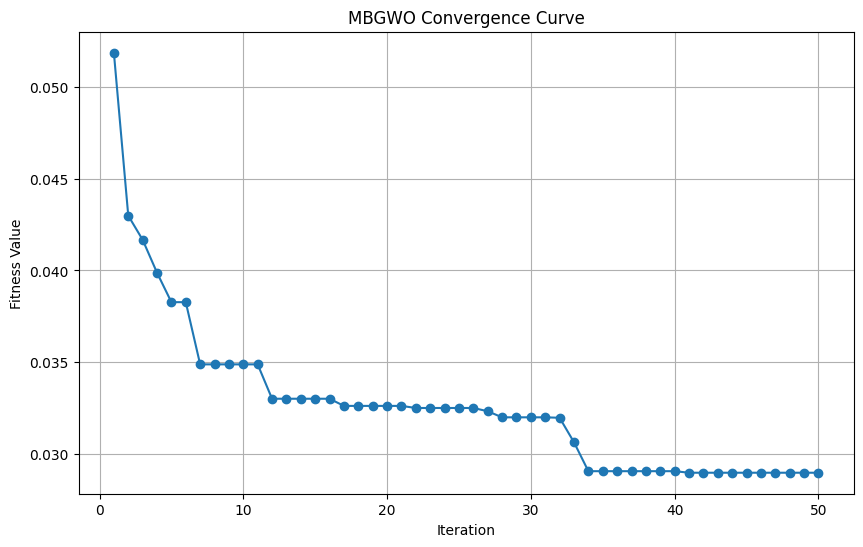

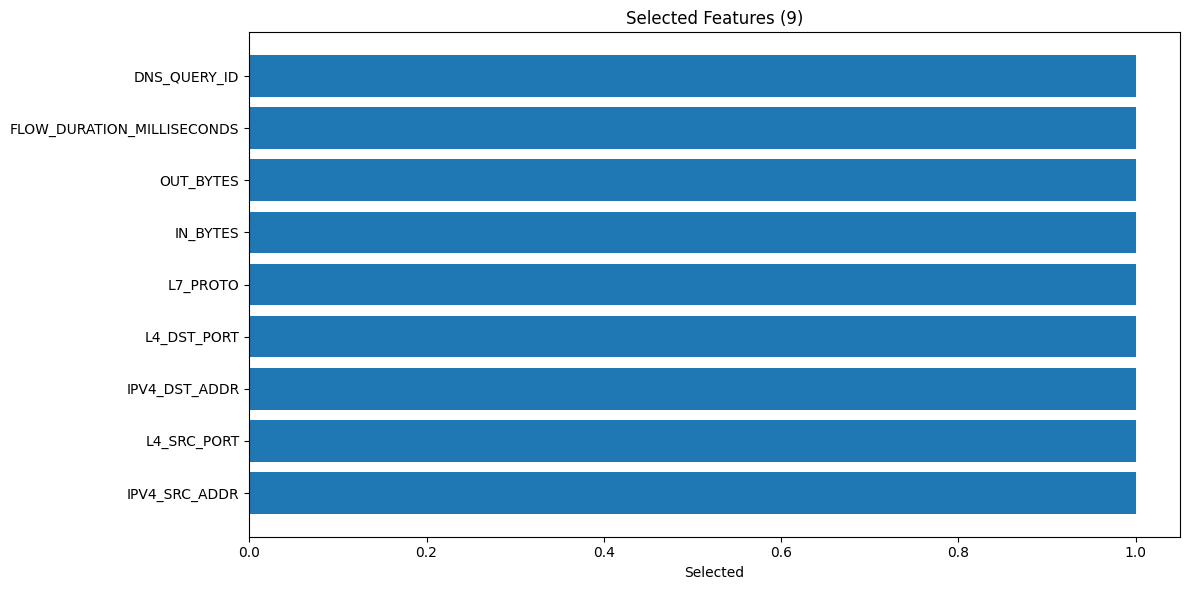

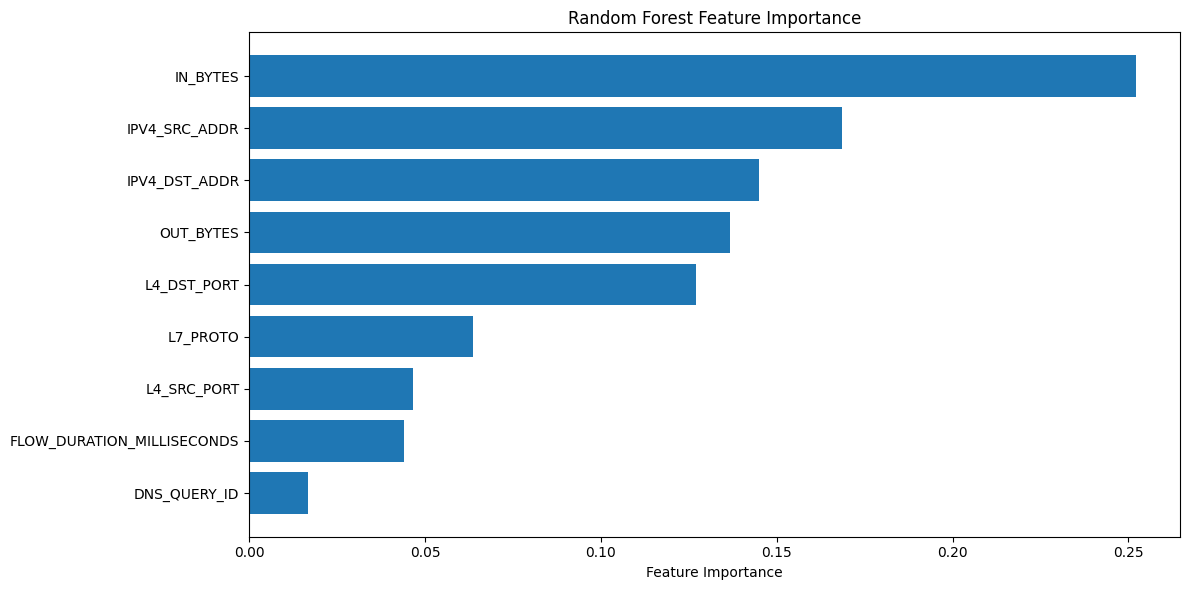

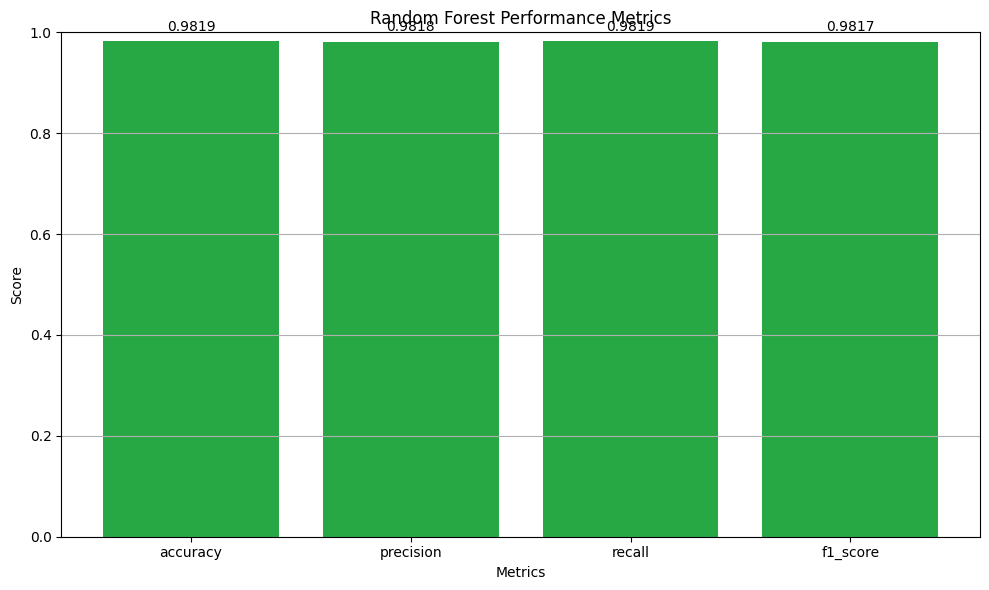

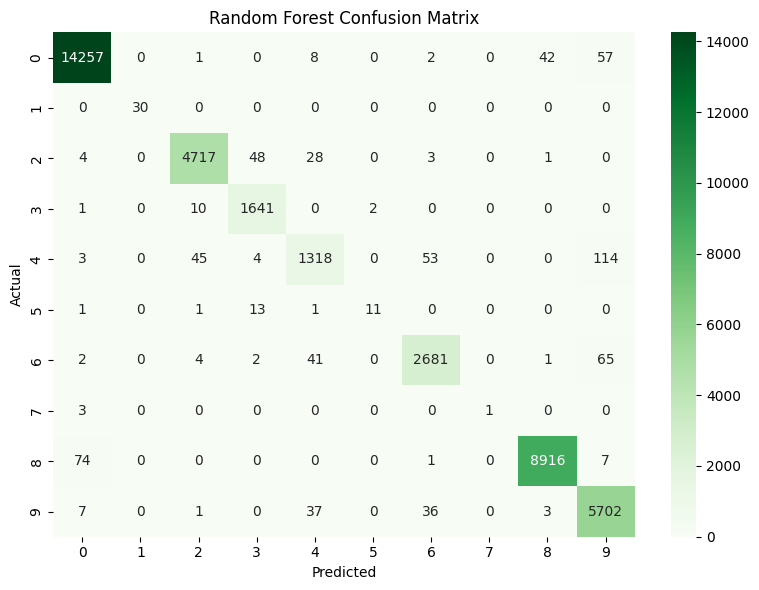

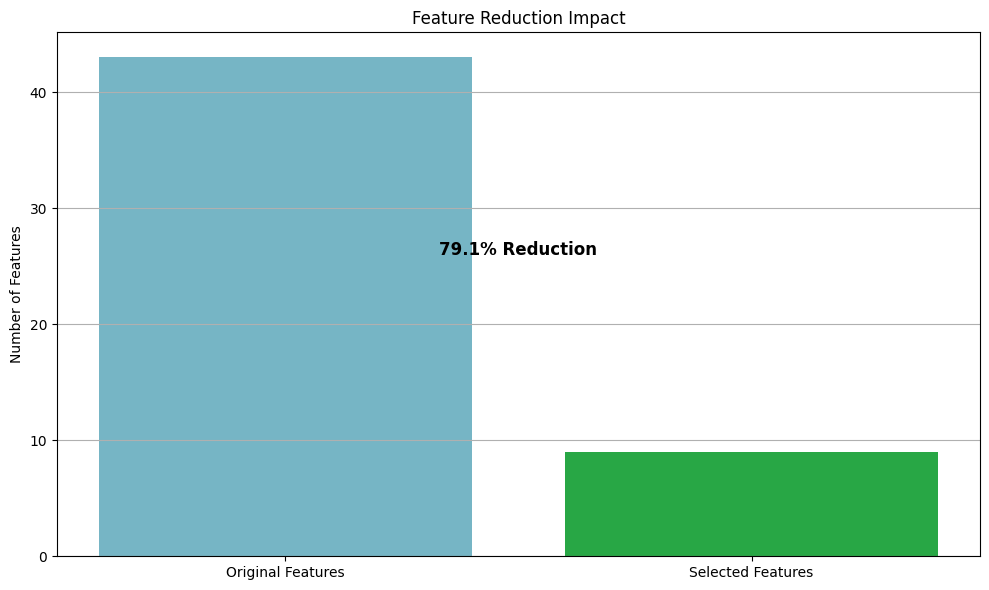

In [12]:
# Plot results
plot_results(convergence_curve, rf_results, selected_features, feature_names, y_test, y_pred_rf)

In [3]:
# Test predictions with a random sample
test_prediction(original_df, X, y, selected_features, feature_names, rf_model, encoders, scaler, sample_random=True)

NameError: name 'test_prediction' is not defined

In [2]:
# Ask if user wants to enter their own values for prediction
user_input = input("\nWould you like to enter your own values for prediction? (y/n): ")
if user_input.lower() == 'y':
    test_prediction(original_df, X, y, selected_features, feature_names, rf_model, encoders, scaler, sample_random=False)

NameError: name 'test_prediction' is not defined